In [145]:
import data_utils
import torch as ch
import argparse
import numpy as np
from ogb.nodeproppred import Evaluator
from livelossplot import PlotLosses
import torch.nn.functional as F
from tqdm import tqdm

time: 1.28 ms (started: 2021-03-12 12:27:09 -05:00)


In [4]:
device = f'cuda:{0}'
device = ch.device(device)

In [57]:
def train_model(ds, model, evaluator, epochs=50, lr=1e-2):
    run_accs = {
        "train": [],
        "test": []
    }

    train_idx, test_idx = ds.get_idx_split()
    liveloss = PlotLosses()

    model.reset_parameters()
    optimizer = ch.optim.Adam(model.parameters(), lr=lr)
    iterator = range(1, 1 + epochs)

    for epoch in iterator:
        loss = data_utils.train(model, ds.data, train_idx, optimizer)
        train_acc, test_acc = data_utils.test(
            model, ds.data, train_idx, test_idx, evaluator)
        
        # At this stage, model in eval mode
        with ch.no_grad():
            out = model(ds.data.x, ds.data.adj_t)[test_idx]
            val_loss = F.nll_loss(out, ds.data.y.squeeze(1)[test_idx])
            val_loss = val_loss.item()
        # train() will switch it to train mode
        # so need not worry about changing modes
            
        logs = {
            "loss": loss,
            "val_loss": val_loss,
            "acc": train_acc,
            "val_acc": test_acc,
        }
            
        # Plot losses live
        liveloss.update(logs)
        liveloss.send()

time: 3.87 ms (started: 2021-03-12 10:36:49 -05:00)


In [30]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 913 µs (started: 2021-03-11 18:52:12 -05:00)


## GCN Models

### Train on Victim Data (~75-80 epochs seems sufficient)

In [61]:
ds = data_utils.ArxivNodeDataset(device, split='victim')    
evaluator = Evaluator(name='ogbn-arxiv')

time: 844 ms (started: 2021-03-12 10:39:19 -05:00)


In [62]:
model = data_utils.GCN(ds.num_features, 256, ds.num_classes, 3, 0.5).to(device)

time: 4.66 ms (started: 2021-03-12 10:39:20 -05:00)


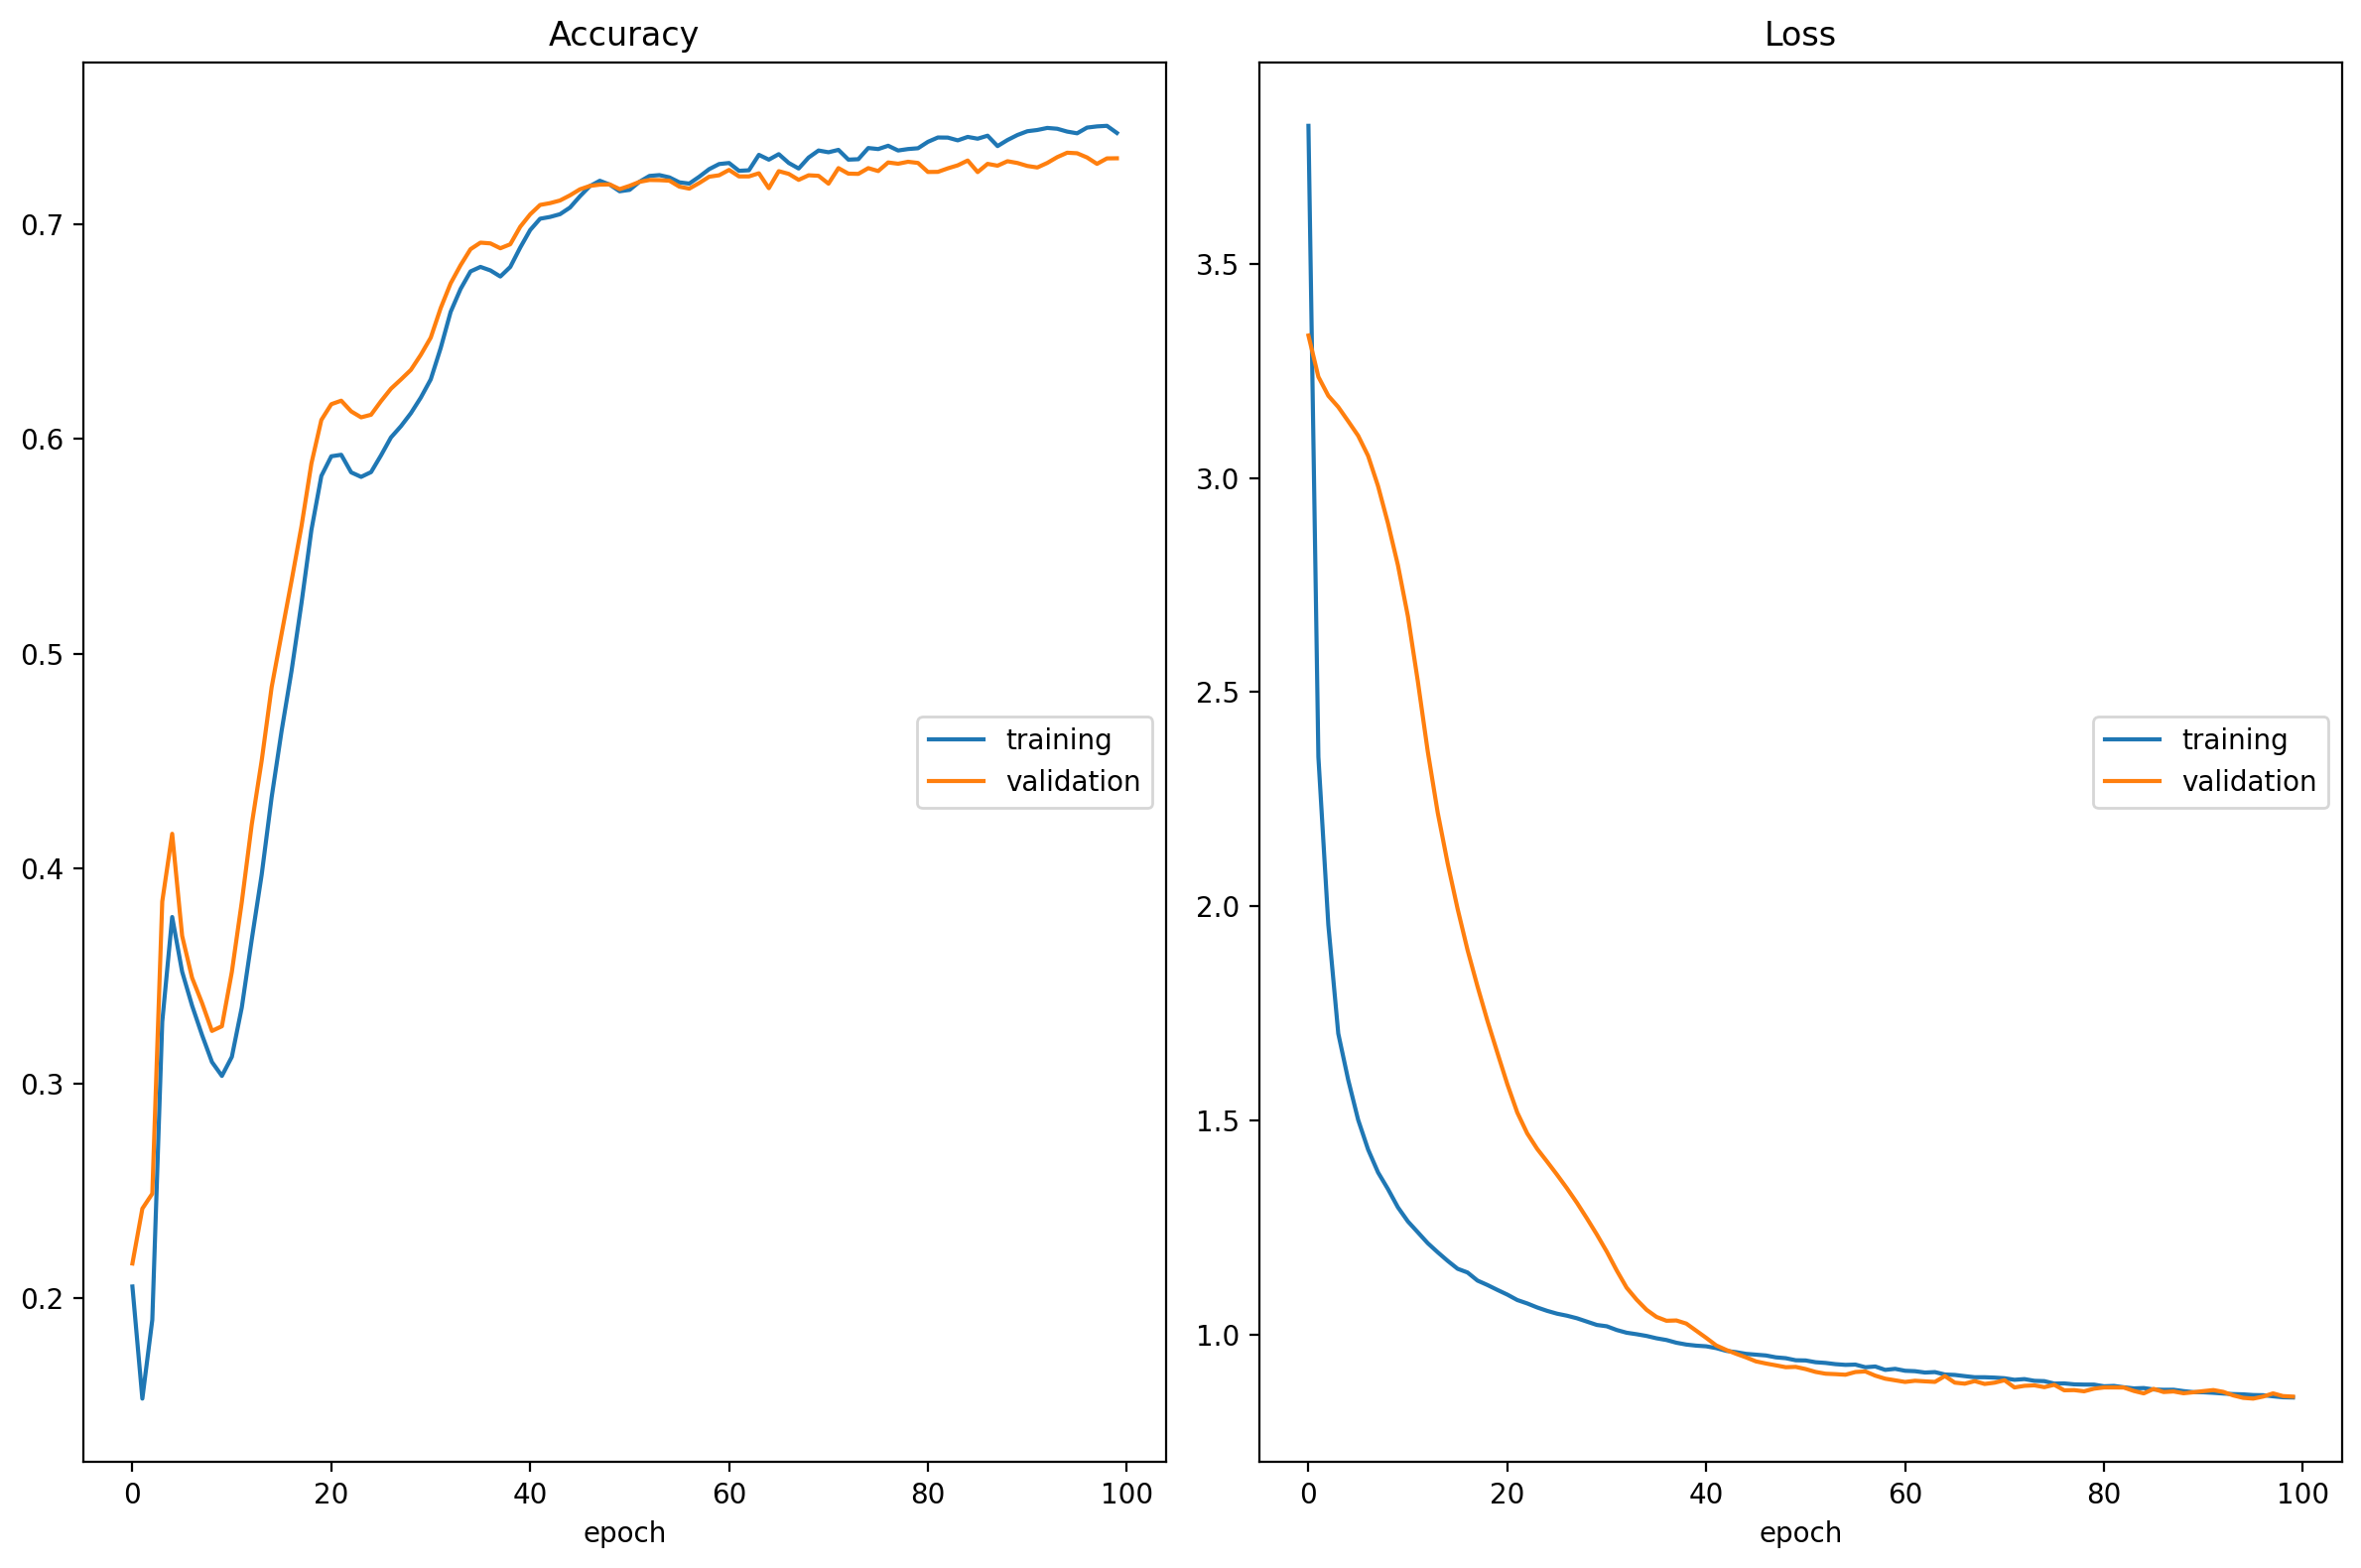

Accuracy
	training         	 (min:    0.153, max:    0.746, cur:    0.742)
	validation       	 (min:    0.216, max:    0.733, cur:    0.731)
Loss
	training         	 (min:    0.854, max:    3.822, cur:    0.854)
	validation       	 (min:    0.851, max:    3.332, cur:    0.856)
time: 1min 57s (started: 2021-03-12 10:39:20 -05:00)


In [63]:
train_model(ds, model, evaluator, epochs=100)

### Train on Adversary Data  (~75-80 epochs seems sufficient)

In [58]:
ds = data_utils.ArxivNodeDataset(device, split='adv')    
evaluator = Evaluator(name='ogbn-arxiv')

time: 913 ms (started: 2021-03-12 10:36:53 -05:00)


In [59]:
model = data_utils.GCN(ds.num_features, 256, ds.num_classes, 3, 0.5).to(device)

time: 4.59 ms (started: 2021-03-12 10:36:54 -05:00)


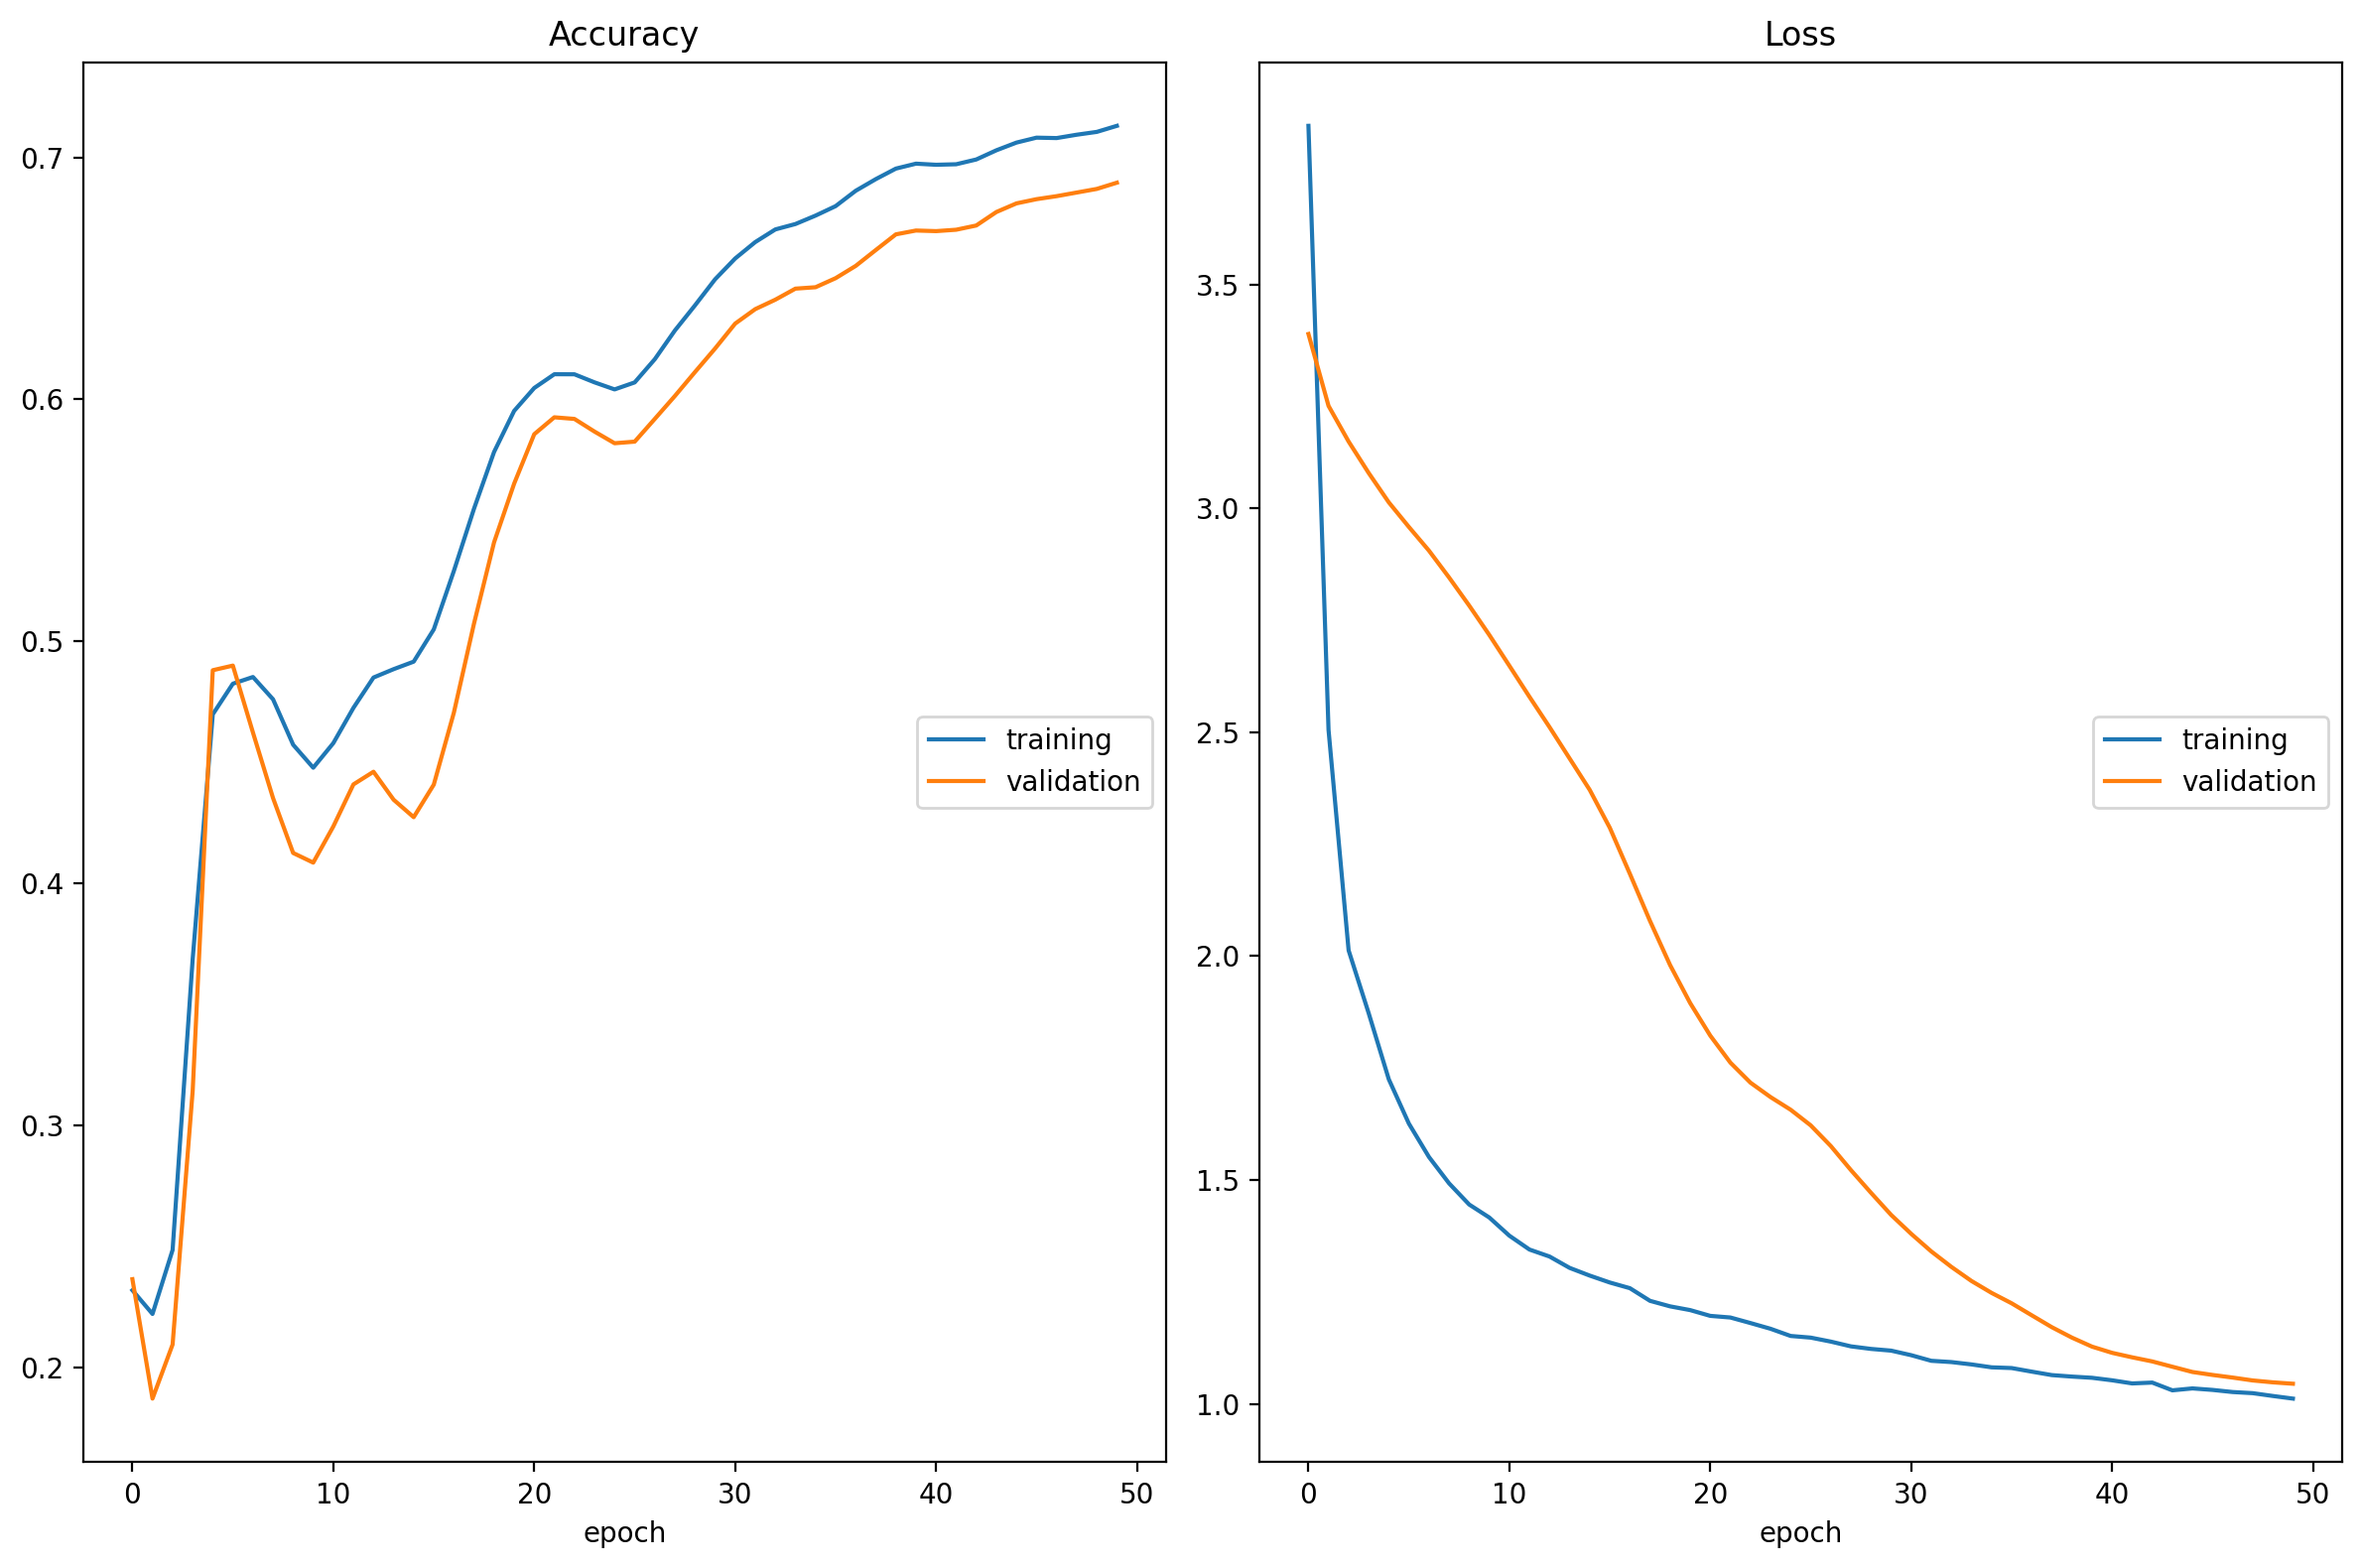

Accuracy
	training         	 (min:    0.222, max:    0.713, cur:    0.713)
	validation       	 (min:    0.187, max:    0.690, cur:    0.690)
Loss
	training         	 (min:    1.012, max:    3.854, cur:    1.012)
	validation       	 (min:    1.045, max:    3.389, cur:    1.045)
time: 59.1 s (started: 2021-03-12 10:36:54 -05:00)


In [60]:
train_model(ds, model, evaluator)

## SAGE Models (tend to overfit, larger generalization gap)

### Train on Victim Data

In [24]:
%%notify
ds = data_utils.ArxivNodeDataset(device, split='victim')    
evaluator = Evaluator(name='ogbn-arxiv')

time: 1.54 s (started: 2021-03-11 18:36:16 -05:00)


<IPython.core.display.Javascript object>

time: 1.55 s (started: 2021-03-11 18:36:16 -05:00)


In [14]:
model = data_utils.SAGE(ds.num_features, 256, ds.num_classes, 3, 0.5).to(device)

time: 14.2 ms (started: 2021-03-11 18:08:55 -05:00)


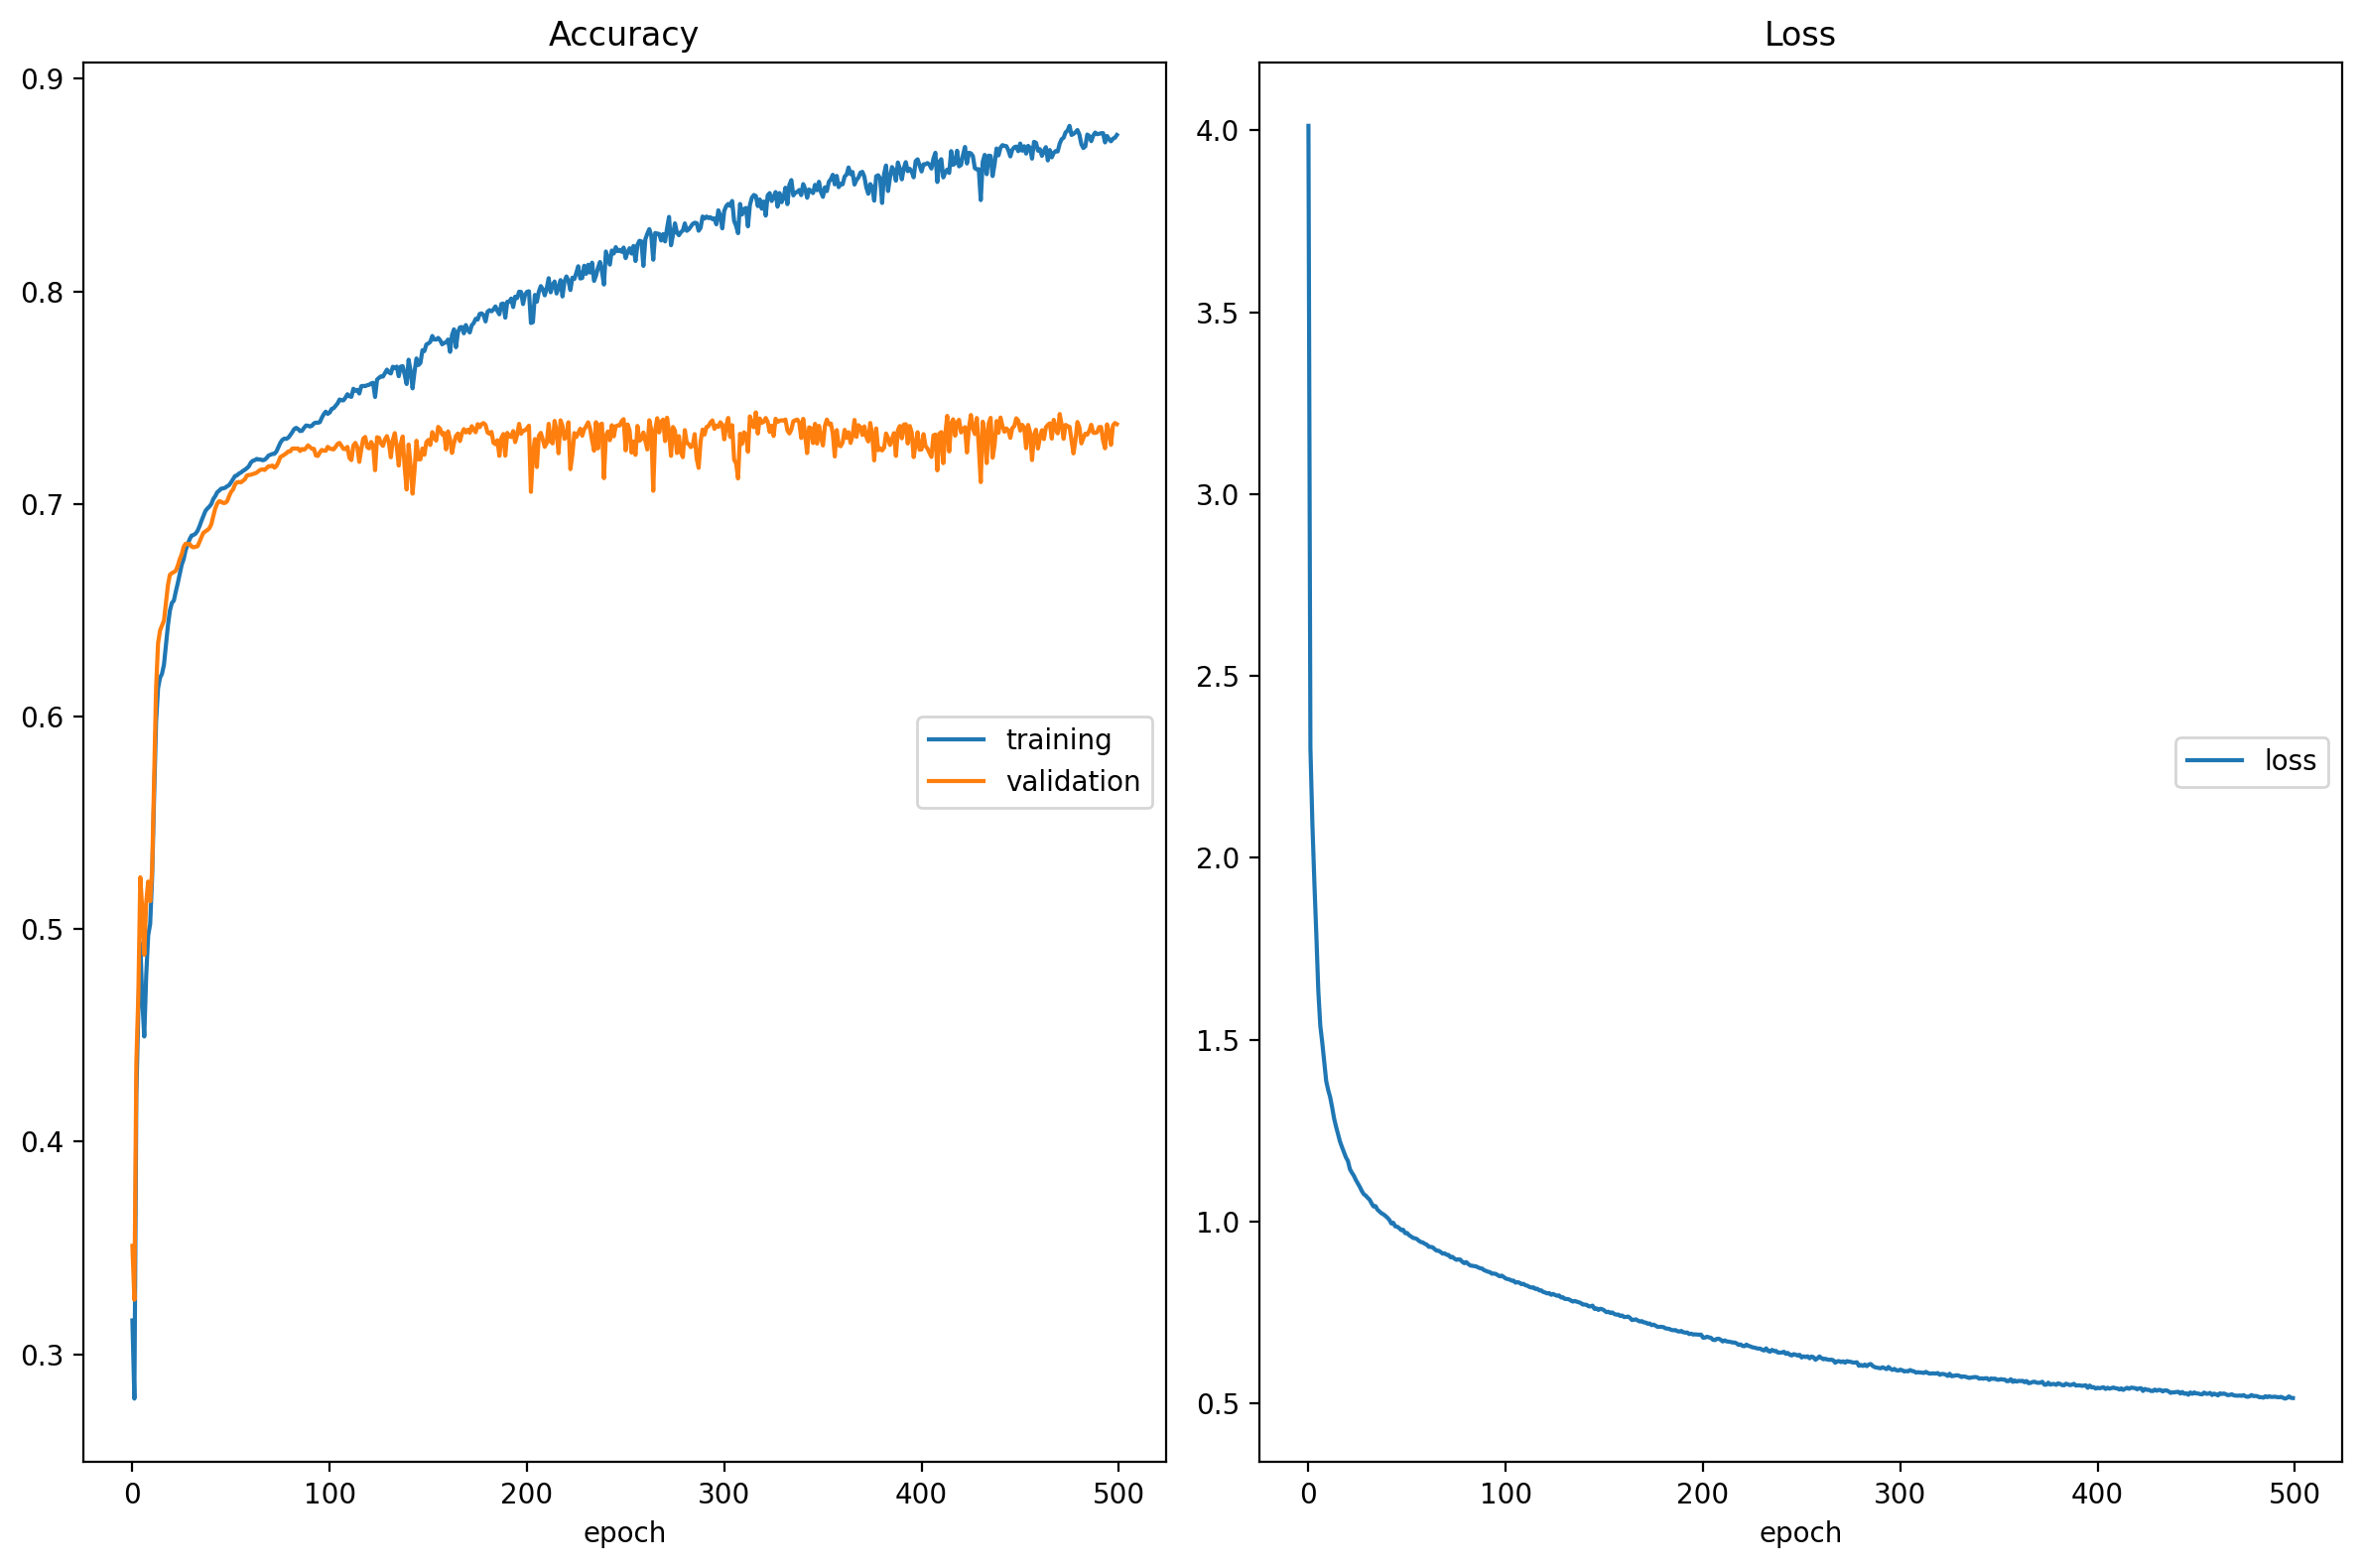

Accuracy
	training         	 (min:    0.279, max:    0.878, cur:    0.874)
	validation       	 (min:    0.326, max:    0.743, cur:    0.738)
Loss
	loss             	 (min:    0.513, max:    4.013, cur:    0.515)
time: 12min 35s (started: 2021-03-11 18:08:55 -05:00)


In [15]:
train_model(ds, model, evaluator)

### Train on Adversary Data

In [16]:
ds = data_utils.ArxivNodeDataset(device, split='adv')    
evaluator = Evaluator(name='ogbn-arxiv')

time: 1.47 s (started: 2021-03-11 18:21:30 -05:00)


In [17]:
model = data_utils.SAGE(ds.num_features, 256, ds.num_classes, 3, 0.5).to(device)

time: 23.8 ms (started: 2021-03-11 18:21:32 -05:00)


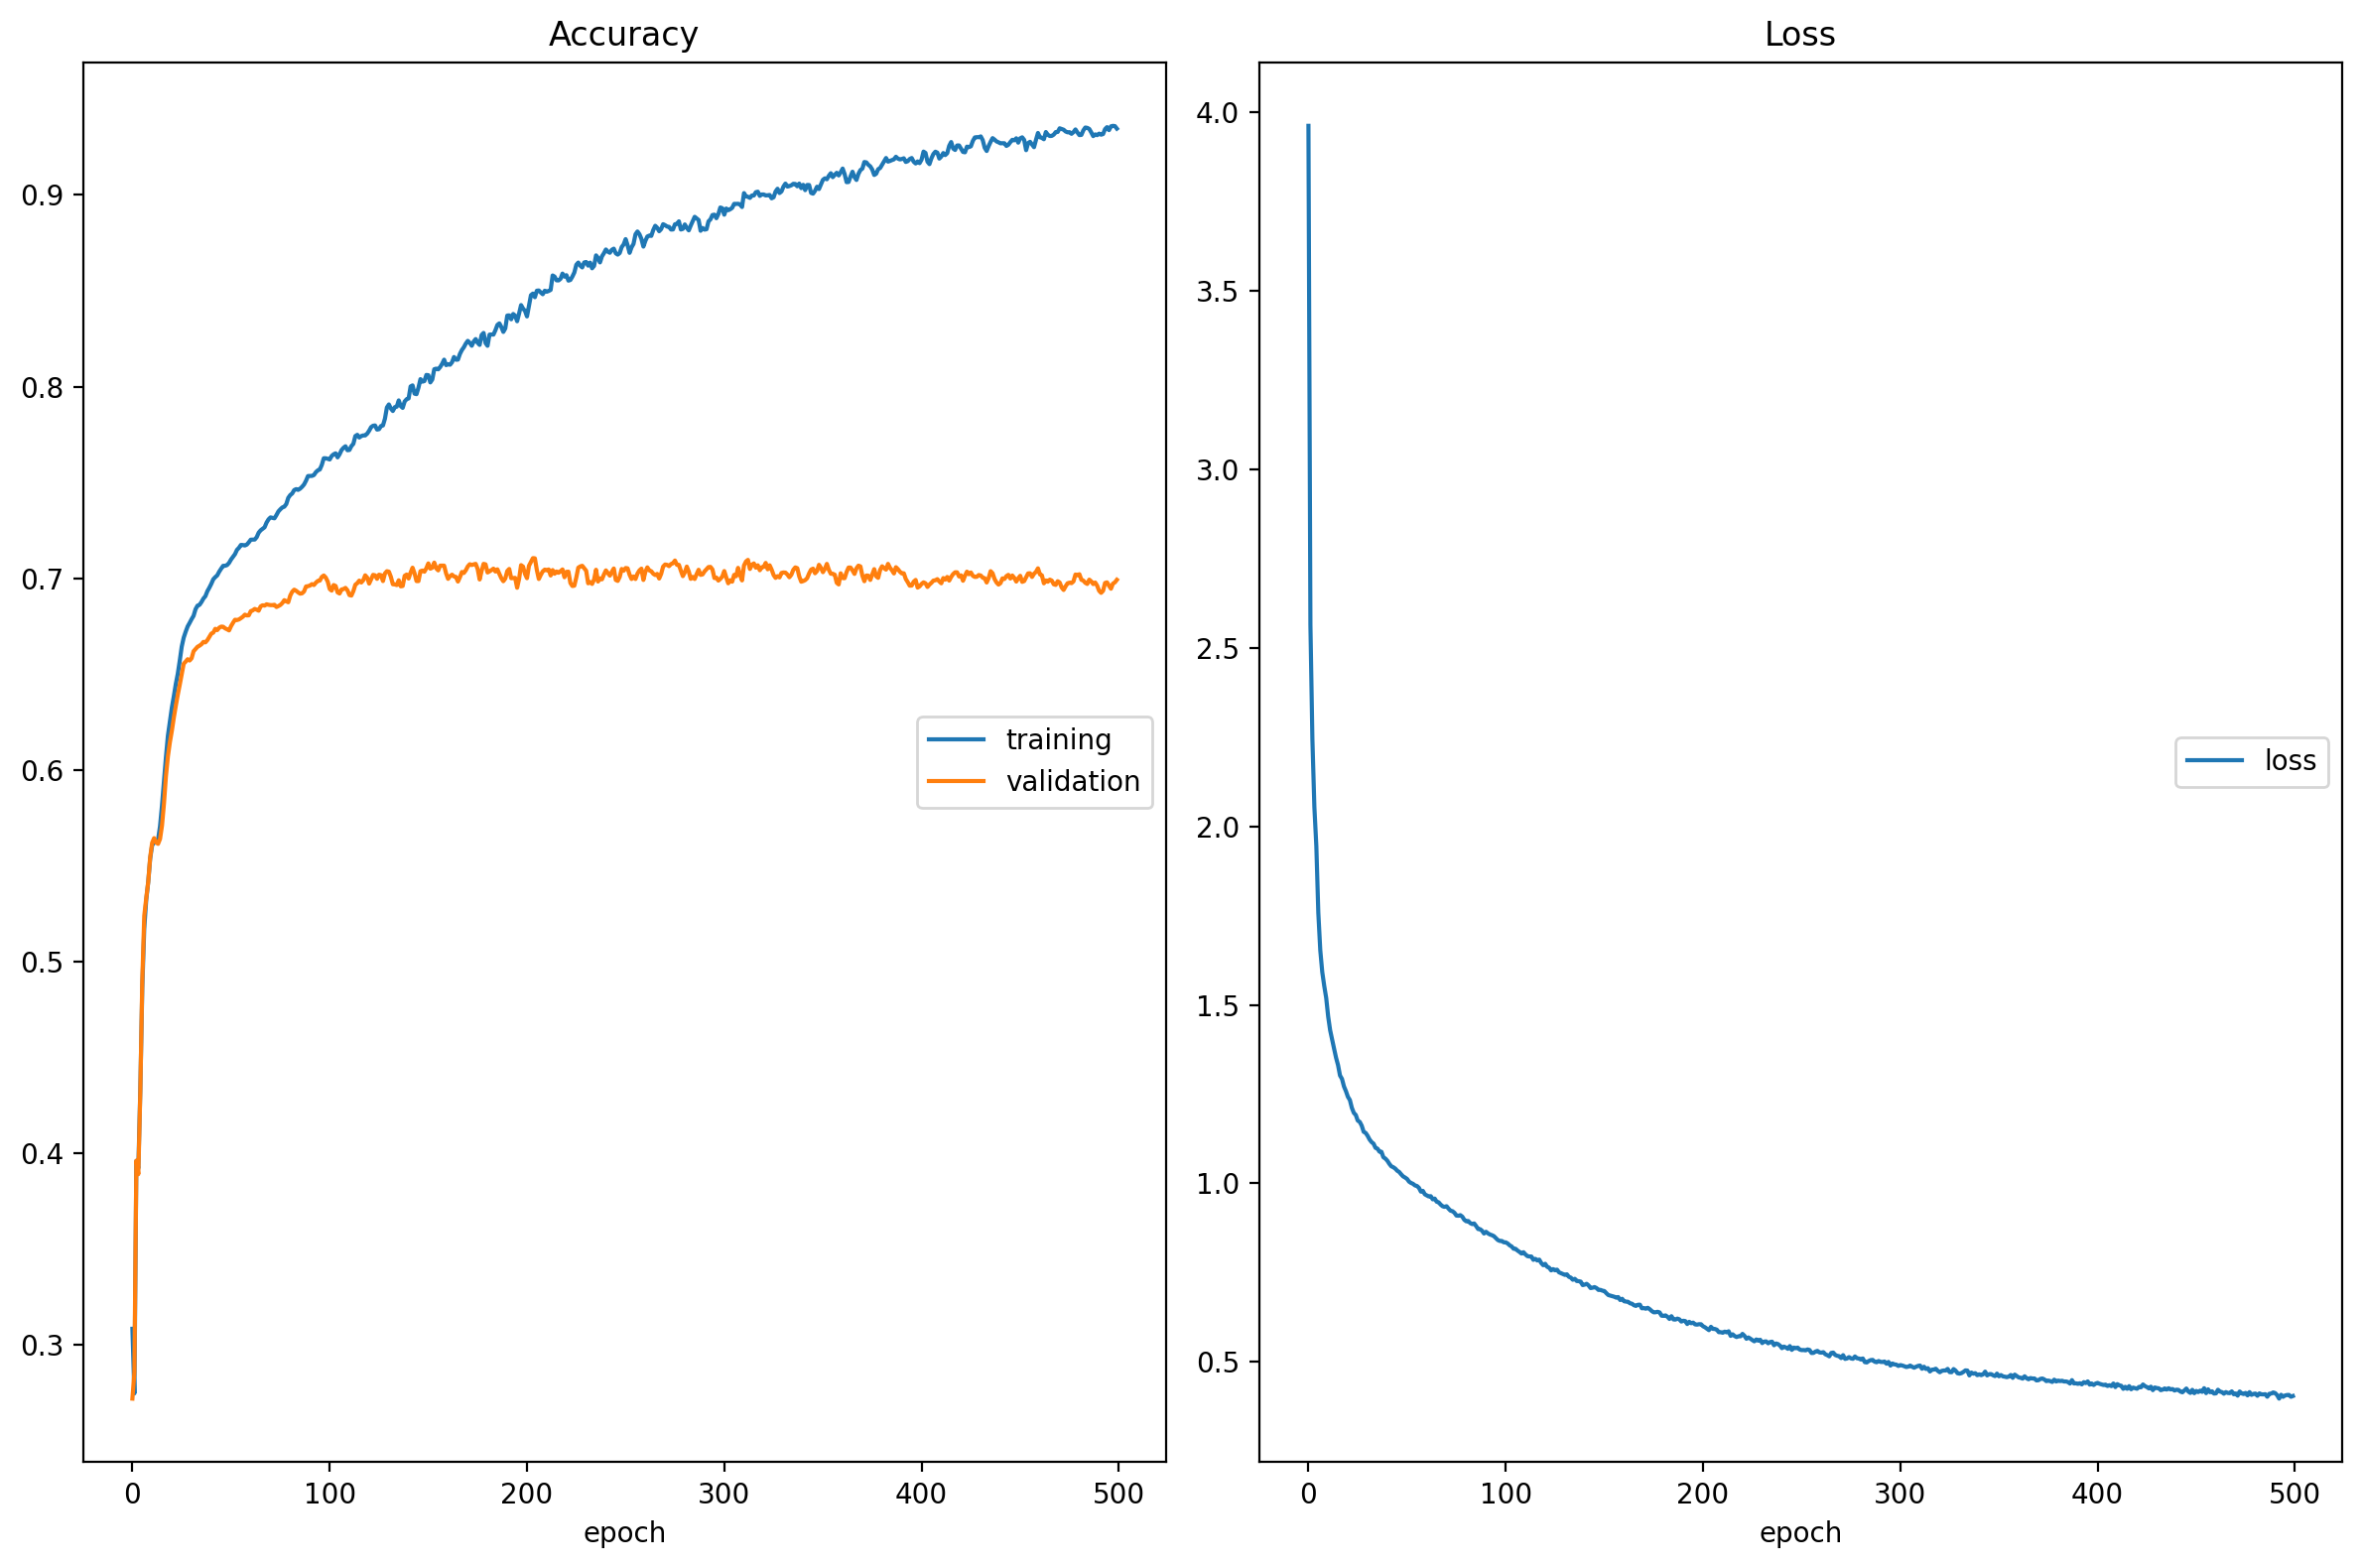

Accuracy
	training         	 (min:    0.274, max:    0.936, cur:    0.935)
	validation       	 (min:    0.272, max:    0.710, cur:    0.699)
Loss
	loss             	 (min:    0.397, max:    3.963, cur:    0.404)
time: 12min 31s (started: 2021-03-11 18:21:32 -05:00)


In [18]:
train_model(ds, model, evaluator)

## Data Exploration

In [76]:
print(ds.data.num_edges)
print(ds.data.num_nodes)

print(len(ds.data.x))

2315598
169343
169343
time: 1.23 ms (started: 2021-03-12 11:43:16 -05:00)


In [77]:
print(ds.data.adj_t)

SparseTensor(row=tensor([     0,      0,      0,  ..., 169341, 169342, 169342], device='cuda:0'),
             col=tensor([   411,    640,   1162,  ..., 163274,  27824, 158981], device='cuda:0'),
             size=(169343, 169343), nnz=2315598, density=0.01%)
time: 16.8 ms (started: 2021-03-12 11:44:29 -05:00)


In [103]:
adjt = ds.data.adj_t

time: 472 µs (started: 2021-03-12 12:20:10 -05:00)


In [147]:
degs = []
for i in tqdm(range(ds.data.num_nodes)):
    degs.append(adjt[i].nnz())
degs = np.array(degs)

100%|██████████| 169343/169343 [00:23<00:00, 7272.94it/s]

time: 23.3 s (started: 2021-03-12 12:27:20 -05:00)


In [151]:
# Should be the same
print(np.mean(degs))
print(ds.data.num_edges / ds.data.num_nodes)
print("Median node degree: %d" % np.median(degs))

13.674010735607613
13.674010735607613
Median node degree: 6
time: 4.14 ms (started: 2021-03-12 12:29:25 -05:00)


In [152]:
dir(adjt[-1])

['__add__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__matmul__',
 '__module__',
 '__mul__',
 '__narrow_diag__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add',
 'add_',
 'add_nnz',
 'add_nnz_',
 'avg_bandwidth',
 'avg_col_length',
 'avg_row_length',
 'bandwidth',
 'bandwidth_proportion',
 'bfloat16',
 'bool',
 'byte',
 'char',
 'clear_cache_',
 'clone',
 'coalesce',
 'coo',
 'copy',
 'cpu',
 'csc',
 'csr',
 'cuda',
 'density',
 'detach',
 'detach_',
 'device',
 'device_as',
 'dim',
 'double',
 'dtype',
 'eye',
 'fill_cache_',
 'fill_diag',
 'fill_value',
 'fill_value_',
 'float',
 'from_dense',
 'from_edge_index',
 'from_scipy'

time: 19.8 ms (started: 2021-03-12 12:36:27 -05:00)
